In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 6)

In [10]:
import sys
import os
import json
import torch
import yaml
import numpy as np#Set plt output
from torchvision import transforms
import torchvision.transforms as T
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from nerfstudio.engine.trainer import Trainer
from nerfstudio.utils.eval_utils import eval_setup

In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/5_spins_with_noise/plane-nerf/2023-11-27_101812"
INPUT_IMG = "/workspace/plane-nerf/data/5_spins/images/0.png"
TARGET_IMG = "/workspace/plane-nerf/data/5_spins/images/5.png"

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")

config = yaml.load(Path(config_path).read_text(), Loader=yaml.Loader)

_, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

outputs/5_spins_with_noise/plane-nerf/2023-11-27_101812/nerfstudio_models


Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/5_spins_with_noise/plane-nerf/2023-11-27_101812/nerfstudio_models/step-000009999.ckpt

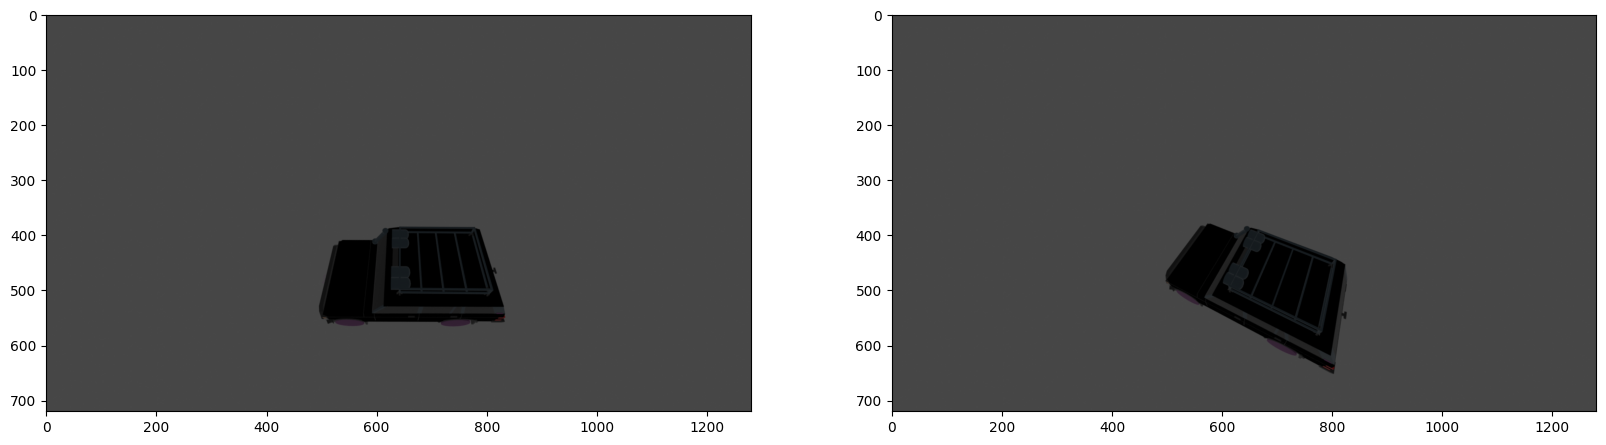

In [6]:
input_image_np = np.array(Image.open(INPUT_IMG).convert("RGB"))
target_image_np = np.array(Image.open(TARGET_IMG).convert("RGB"))

#Show in plt subplot
fig, ax = plt.subplots(1, 2)
ax[0].imshow(input_image_np)
ax[1].imshow(target_image_np)

In [21]:
def get_image_to_tensor_balanced(image_size=0):
    ops = []
    if image_size > 0:
        ops.append(transforms.Resize(image_size))
    ops.extend(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
    )
    return transforms.Compose(ops)

in_sz = input_image_np.shape[0]
image_to_tensor = get_image_to_tensor_balanced()
device = torch.device("cuda:%d" % 0)

# Encoding the input image.
print(f"Input image: {INPUT_IMG}")
input_image = Image.fromarray(input_image_np)
input_image = T.Resize(in_sz)(input_image)
input_image = image_to_tensor(input_image).to(device=device)
input_pose = torch.eye(4)

print(f"Target image: {TARGET_IMG}")
target_image = Image.fromarray(target_image_np)
target_image = T.Resize(in_sz)(target_image)
target_image_flatten = np.reshape(target_image, [-1, 3]) / 255.0
target_image_flatten = torch.from_numpy(target_image_flatten).float().to(device=device)

cam_pose = torch.clone(input_pose.detach()).unsqueeze(0)
cam_pose.requires_grad = True

print("Input pose:")
print(f"{input_pose}")
print("Init pose:")
print(f"{cam_pose[0]}")

# Create optimizer.
optimizer = torch.optim.Adam(params=[cam_pose], lr=0.001)
n_steps = 100 + 1

# Loss.
mse_loss = torch.nn.MSELoss()




Input image: /workspace/plane-nerf/data/5_spins/images/0.png
Target image: /workspace/plane-nerf/data/5_spins/images/5.png
Input pose:
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Init pose:
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], grad_fn=<SelectBackward0>)
